# Assignment 2: Speech Production and Models
#### EQ2321 Speech and Audio Signal Processing

Max. grade: 38

# Introduction

Throughout this assignment we will use the speech data in `data["speech8"]` which is sampled at 8 kHz. `speech8` will be used both for tuning (training, optimizing) and evaluating the speech coders (evaluating on the training data is called closed test evaluation). Normally this is considered inappropriate (why?), but
we accept it here for simplicity.
You will frequently be asked to evaluate the SNR which is calculated like
$SNR = 10 \log 10 \frac{\sigma_x^2}{\sigma_q^2}$, where $X(n)$ is input speech to the coder, and $q(n) =
X(n) − \hat{X}(n)$ is the quantization error, where $\hat{X}(n)$ is the quantized speech.
Thus, calculating the SNR amounts to estimating $\sigma_x^2$, and $\sigma_q^2$.
Please note that the last part of the assignment may be the most time
consuming. There you are asked to design a forward gain and filter adaptive
DPCM coder and you are not given many instructions. Make sure you allocate
enough time for this last part!

## The Uniform Scalar Quantizer (4 pts)

In this task we implement the simplest quantizer of all: the uniform scalar
quantizer (USQ). USQs will be used frequently in this assignment.
Encoding and transmission by USQ is sometimes called Pulse Code Modulation (PCM).

In [4]:
import numpy as np
import pickle as pkl

In [5]:
def read_assignment_file(fname):
    with open(fname,"rb") as f:
        d=pkl.load(f)
    return d

assignment_file = "assignment2.pkl"
data=read_assignment_file(assignment_file)
# print(data,'check what is inside d')   # dict type
print(data["speech8"],'check speech8' '\n', data["speech8"].shape, 'shape of speech8')

[[  1.60155162]
 [  2.62439824]
 [  1.43115507]
 ...
 [-19.6068527 ]
 [ -0.22280581]
 [  0.41062539]] check speech8
 (46030, 1) shape of speech8


### Question 1

Implement a uniform scalar encoder:

```python
def sq_enc(xin, n_bits, xmax, m):
    """
    xin is a vector with the original speech samples,
    n_bits is the number of bits available to quantize one sample in the quantizer (i.e., the rate),
    xmax and m define the range of the quantizer from m-xmax to m+xmax,
       so that the width of each quantization interval is ∆ = 2 × xmax/L,
           where L is the number of quantization intervals and corresponding reconstruction values.
       m defines the mean (or offset) of the quantizer reconstruction levels.

    The function should return the index of the chosen quantization level.
    """

    return idx
```

Setting m = 0 defines a “midrise” quantizer, and m = $\frac{\Delta}{2}$ gives a "midtread" quantizer (see the course book sec. 7.2).


Implement also the corresponding decoder function
```python
def sq_dec(idx, n_bits, xmax, m)
    """See sq_enc for the definition of the inputs.
    outq is the vector with the quantized values for idx.
    """
    return outq
```
The USQ is a highly structured quantizer. The encoder can be imple-
mented essentially by only a scalar division (no multiplications, compar-
isons or loops are needed), making the computational complexity inde-
pendent of the bitrate. Make sure your encoder has a computational
complexity independent of the bitrate!


In [6]:
def sq_enc(xin, n_bits, xmax, m):
    """
    xin is a vector with the original speech samples,
    n_bits is the number of bits available to quantize one sample in the quantizer (i.e., the rate),
    xmax and m define the range of the quantizer from m-xmax to m+xmax,
       so that the width of each quantization interval is ∆ = 2 × xmax/L,
           where L is the number of quantization intervals and corresponding reconstruction values.
       m defines the mean (or offset) of the quantizer reconstruction levels.

    The function should return the index of the chosen quantization level.
    """
    L = 2**n_bits
    offset = m-xmax
    delta = (2*xmax)/L
    n = len(xin)
    idx = np.zeros((n))   # check shape
    # print(idx.shape,'idx matrix shape')
    for i in range(n-1):   # for each sample
        d = xin[i] - offset
        if d < delta:
            idx[i] = 0
        elif d >= (L-1)*delta:
            idx[i] = L-1
        else:
            idx[i] = np.floor(d/delta)

    return idx

x = np.linspace(-6,6,1201)
idx_test = sq_enc(x, 2, 4, 0)


def sq_dec(idx, n_bits, xmax, m):
    """See sq_enc for the definition of the inputs.
    outq is the vector with the quantized values for idx.
    """
    L = 2**n_bits
    delta = 2*xmax/L
    offset = m - xmax
    outq = offset+(2*idx+1)*(delta/2)
    return outq

### Question 2 (4 pts)

Run the encoder and decoder on a ramp signal `x=np.linspace(-6,6,1201)`. Use a `2-bit` quantizer with $x_{max} = 4$.

Plot the quantizer output as a function of the input.

Make sure the output levels are exactly where you expect them to be.

Use a quantizer mean $m=0$. Do a similar plot with $m=1.5$.

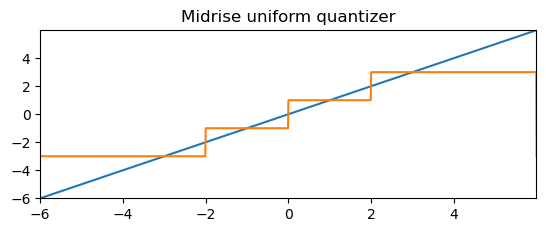

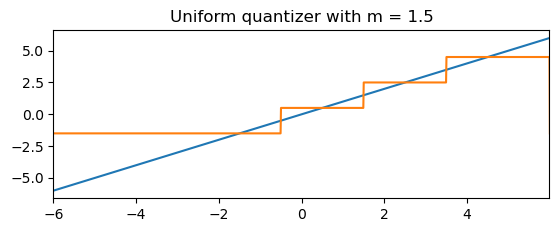

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-6,6,1201)
n_bits = 2
xmax = 4
m1 = 0
m2 = 1.5
idx1 = sq_enc(x,n_bits,xmax,m1)
outq1 = sq_dec(idx1,n_bits,xmax,m1)
idx2 = sq_enc(x,n_bits,xmax,m2)
outq2 = sq_dec(idx2,n_bits,xmax,m2)

plt.figure()
plt.subplot(211)
plt.plot(x,x)
plt.plot(x,outq1)
plt.xlim(-6,5.99)
plt.ylim(-6,5.99)
plt.title('Midrise uniform quantizer')
plt.show()

plt.figure()
plt.subplot(212)
plt.plot(x,x)
plt.xlim(-6,5.99)
plt.plot(x,outq2)
plt.title('Uniform quantizer with m = 1.5')
plt.show()


## Parametric Coding of Speech (23 pts)

In this task we complete our design of the vocoder from assignment 1.
Note that the speech used in this assignment is different from assignment 1 and if
your vocoder analysis is not robust you may have to retune the analysis for this
assignment.
You are encouraged to use your own vocoder.
However, it must produce a quality that is at least as high as our vocoder provided to you.
If not, then you have to get aquainted with our vocoder, and use that in the following.
In practice, a speech coder must operate on a frame-by-frame basis, and transmit compressed data as quickly as possible in order to keep the delay short.
However, you may have implemented your vocoder in an off-line fashion (the pitch estimator is easier to implement like that for example).
This is acceptable also here.

### Quantizing the Gain (8 pts)

In [70]:
from scipy import signal
from scipy.linalg import solve_toeplitz
import sounddevice as sd


def x_corr(x,y,M=10):
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    idx=(lags>=-M) & (lags<=M)
    corr = corr[idx]
    lags=lags[idx]
    return lags[len(lags)//2:], corr[len(lags)//2:]   # truncate，len(lags) = 21, corr(only remain last 11 values)

def analysis(x, alen, ulen, M):
    naf = (len(x)-alen+ulen) // ulen  # Number of analysis frames
    threshold = 0.3
    E, A = np.zeros((naf, 1)), np.zeros((naf, M+1))
    ZC, V, P = [], [], []

    for n in range(naf):
        xf = x[n*ulen:n*ulen+alen, 0].astype(np.float32)
        for i in range(alen):
            E[n, 0] = E[n, 0] + xf[i]**2
        E[n, 0] = E[n, 0] / alen
        n_zero = 0
        xf_find_zero = xf.tolist()
        zero_decider = [xf_find_zero[j] * xf_find_zero[j-1] for j in range(1,alen)]
        for num in zero_decider:
            n_zero += 1 if num < 0 else 0
        ZC.append(n_zero/alen)     # The normalized number of zero crossings
        V.append(1) if n_zero/alen < threshold else V.append(0)
        lags1, r = x_corr(xf, xf, M=M)  # acf
        A[n,:] = np.concatenate([np.ones(1), solve_toeplitz(r[:-1], -r[1:])]).ravel()
        peak_index, peak_value = [], []
        d_find = list(signal.correlate(xf, xf,'full')[alen-1:])
        for i in range(len(d_find)-1):
            if d_find[i]>d_find[i-1] and d_find[i]>d_find[i+1]:   # denote peak
                peak_index.append(i)
                peak_value.append(d_find[i])
        peak_index, peak_value = peak_index[1:], peak_value[1:]
        P.append(peak_index[peak_value.index(max(peak_value))])    # Pitch period in samples
    ZC, V = np.array(ZC), np.array(V)

    return E, ZC, V, A, P

def synthesis(E, ZC, V, A, P, ulen):
    n_frames = A.shape[0]
    nexc = np.random.random(n_frames*ulen)
    n1 = 0
    Z = np.array([])
    sound = np.zeros((n_frames*ulen))
    for n in range(0, n_frames):
        pexc, cp = np.zeros((n_frames*ulen)), P[n]
        pexc[0::cp] = 1
        exc = pexc if V[n] == 1 else nexc
        if Z.shape[0] == 0: # 1st iteration
            sound[n1:n1+ulen] = signal.lfilter(np.array([1]), A[n,:], exc[n1:n1+ulen])
            Z = signal.lfiltic(np.array([1]), A[n,:], sound[n1:n1+ulen], x=exc[n1:n1+ulen])
        else:
            sound[n1:n1+ulen], Z = signal.lfilter(np.array([1]), A[n,:], exc[n1:n1+ulen], zi=Z)
        energy_sum = sum([e**2 for e in sound[n1:n1+ulen]])/ulen
        for i in range(ulen):
            sound[n1+i] = sound[n1+i]*((E[n,0]/energy_sum)**0.5)
        n1 += ulen
    return sound

def play_wav(x,fs):
    sd.play(x.astype(np.int16),fs)

speech_data = x=data["speech8"]
E,ZC,V,A,P = analysis(x=speech_data, alen=256, ulen=128, M=10)
recon_sound = synthesis(E, ZC, V, A, P, ulen=128)

In [52]:
play_wav(speech_data, fs=8000)

In [71]:
play_wav(recon_sound, fs=8000)

#### Question 1 (1 pts)

Provide a plot of the histogram of the gain parameter.
Indicate in the plot the range of the quantizer, i.e., mark the outer boundaries $m\pm xmax$ (also mark m).
Note that the pdf has a non-zero mean.

(array([42., 14., 12., 23., 17.,  7.,  7.,  5.,  9.,  7.,  4.,  4.,  7.,
         1.,  1.,  3.,  3.,  2.,  3.,  4.,  2.,  5.,  5.,  8.,  5.,  1.,
         3.,  1.,  2.,  4.,  2.,  5.,  2.,  3.,  6.,  2.,  2.,  2.,  4.,
         3.,  1.,  5.,  3.,  1.,  2.,  2.,  0.,  0.,  0.,  1.,  4.,  1.,
         3.,  3.,  2.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  0.,  2.,
         2.,  0.,  3.,  3.,  2.,  2.,  0.,  2.,  0.,  3.,  1.,  0.,  2.,
         1.,  2.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  3.,  0.,  0.,  2.,
         0.,  2.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  2.,  0.,  0.,  1.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  3.,  0.,  1.,  1.,
         1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  2.,  0.,  3.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.

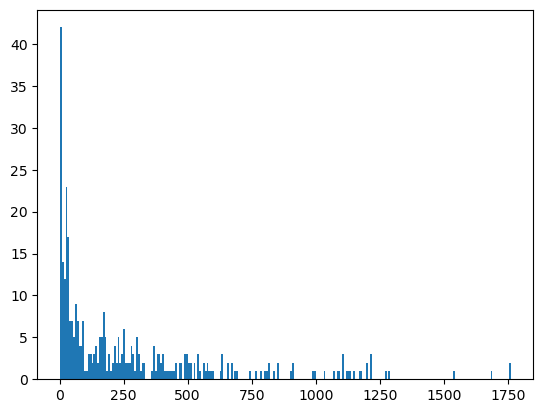

In [104]:
def gain_shape(x_origin, x_hat):
    """generate gain_factor from a given input vector x_origin and codebook vector x_hat"""
    gain_factor = np.dot(x_origin.T, x_hat)/(np.linalg.norm(x_hat))**2
    return gain_factor

def get_gain_param(x, alen, ulen):
    naf = (len(x)-alen+ulen) // ulen  # Number of analysis frames
    gain_list = []
    for n in range(naf):
        xf = x[n*ulen:n*ulen+alen, 0].astype(np.float32)
        xf_q = sq_enc(xf, n_bits=2, xmax=4, m=1.5)
        gain = np.round(gain_shape(xf, xf_q))
        gain_list.append(gain)
    return gain_list

gain_param = get_gain_param(x=speech_data, alen=256, ulen=128)
plt.hist(x=gain_param, bins=len(set(gain_param)))